In [1]:
import requests
import pandas as pd
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

from sklearn.preprocessing import LabelEncoder


In [2]:
df0 = pd.read_fwf('PCC_cat.txt', header=None)
df0

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,NaN,PCC-0001,49.2355,41.5722,20.51,0.04,1.44,0.10,20.80,1.07,...,0.69,0.25,0.63,0.28,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
1,NaN,PCC-0002,49.2366,41.4013,20.44,0.04,2.18,0.14,21.96,0.79,...,1.53,1.01,1.38,0.97,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
2,NaN,PCC-0003,49.2370,41.4336,21.58,0.04,1.11,0.07,22.41,0.07,...,1.25,0.71,1.19,0.67,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
3,NaN,PCC-0004,49.2377,41.5285,21.03,0.06,1.08,0.10,23.14,0.69,...,0.58,0.25,0.42,0.15,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
4,NaN,PCC-0005,49.2380,41.4346,20.27,0.02,1.24,0.04,21.94,0.80,...,0.70,0.50,0.53,0.48,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5432,NaN,PCC-5433,50.0062,41.2380,20.32,NaN,1.10,NaN,22.53,3.80,...,0.97,0.83,0.93,0.69,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5433,NaN,PCC-5434,50.0064,41.2568,22.63,NaN,0.54,NaN,23.29,0.50,...,1.46,1.12,NaN,NaN,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5434,NaN,PCC-5435,50.0068,41.6048,21.44,0.02,0.61,0.02,21.52,0.43,...,0.59,0.41,NaN,NaN,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5435,NaN,PCC-5436,50.0070,41.3916,21.32,0.07,0.99,0.10,22.86,0.95,...,1.19,1.07,1.06,0.92,NaN,NaN,Cluster or background LTG,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...


In [3]:
df0[21]

0       Likely cluster or background edge-on disk galaxy
1       Likely cluster or background edge-on disk galaxy
2       Likely cluster or background edge-on disk galaxy
3             Likely background ETG or unresolved source
4       Likely cluster or background edge-on disk galaxy
                              ...                       
5432          Likely background ETG or unresolved source
5433    Likely cluster or background edge-on disk galaxy
5434    Likely cluster or background edge-on disk galaxy
5435                           Cluster or background LTG
5436          Likely background ETG or unresolved source
Name: 21, Length: 5437, dtype: object

In [4]:
print(np.unique(df0[21]))
print(len(np.unique(df0[21]))) # number of unique labels

['Cluster or background LTG' 'Likely background ETG or unresolved source'
 'Likely cluster or background edge-on disk galaxy'
 'Likely dE/ETGcluster candidate' 'Likely merging system'
 'Possible dE/ETGcluster candidate'
 'background galaxy with possibly weak substructure']
7


In [29]:
ra = df0[2]
dec = df0[3]
workDir = 'SDSS2'

# df1 = pd.DataFrame()
filenames = []
for r, d in zip(ra, dec):
    fn = f'sdss_ra={r}_dec={d}.jpeg'
    filenames.append(fn)
#     print(fn)

# # turning labels to numbers -- didn't use this method - verify? -- TODO
le = LabelEncoder()
labelToNum = le.fit_transform(df0[21])

df1 = pd.DataFrame({'files' : filenames,
                    'labels': df0[21]})    

print(df1) 
# splitting dataframe by row index
ind = int(5437*.80) # split data 80/20
trainDf = df1.iloc[:ind,:]
testDf = df1.iloc[ind:,:]


                                 files  \
0     sdss_ra=49.2355_dec=41.5722.jpeg   
1     sdss_ra=49.2366_dec=41.4013.jpeg   
2      sdss_ra=49.237_dec=41.4336.jpeg   
3     sdss_ra=49.2377_dec=41.5285.jpeg   
4      sdss_ra=49.238_dec=41.4346.jpeg   
...                                ...   
5432   sdss_ra=50.0062_dec=41.238.jpeg   
5433  sdss_ra=50.0064_dec=41.2568.jpeg   
5434  sdss_ra=50.0068_dec=41.6048.jpeg   
5435   sdss_ra=50.007_dec=41.3916.jpeg   
5436  sdss_ra=50.0089_dec=41.6781.jpeg   

                                                labels  
0     Likely cluster or background edge-on disk galaxy  
1     Likely cluster or background edge-on disk galaxy  
2     Likely cluster or background edge-on disk galaxy  
3           Likely background ETG or unresolved source  
4     Likely cluster or background edge-on disk galaxy  
...                                                ...  
5432        Likely background ETG or unresolved source  
5433  Likely cluster or background edge

C:\Users\Jason\Documents\SJSU\JPAstro


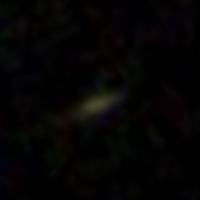

In [6]:
print(os.getcwd())

from keras.preprocessing.image import load_img

load_img('SDSS1/sdss_ra=49.2355_dec=41.5722.jpeg')

In [7]:
trainDf

,files,labels
0,sdss_ra=49.2355_dec=41.5722.jpeg,Likely cluster or background edge-on disk galaxy
1,sdss_ra=49.2366_dec=41.4013.jpeg,Likely cluster or background edge-on disk galaxy
2,sdss_ra=49.237_dec=41.4336.jpeg,Likely cluster or background edge-on disk galaxy
3,sdss_ra=49.2377_dec=41.5285.jpeg,Likely background ETG or unresolved source
4,sdss_ra=49.238_dec=41.4346.jpeg,Likely cluster or background edge-on disk galaxy
...,...,...
4344,sdss_ra=49.8648_dec=41.5081.jpeg,Likely cluster or background edge-on disk galaxy
4345,sdss_ra=49.8649_dec=41.3532.jpeg,Likely dE/ETGcluster candidate
4346,sdss_ra=49.8649_dec=41.2249.jpeg,Cluster or background LTG
4347,sdss_ra=49.8654_dec=41.4619.jpeg,Likely background ETG or unresolved source


In [27]:
x = df1['labels']
x = x.tolist()


# Balance of data
for i in range(7):
    print(x.count(i)/5437)

print(le.classes_)
print(le.transform(le.classes_))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
['Cluster or background LTG' 'Likely background ETG or unresolved source'
 'Likely cluster or background edge-on disk galaxy'
 'Likely dE/ETGcluster candidate' 'Likely merging system'
 'Possible dE/ETGcluster candidate'
 'background galaxy with possibly weak substructure']
[0 1 2 3 4 5 6]


In [9]:


datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)
# datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
dataframe=trainDf,
directory="./SDSS1/",
x_col="files",
y_col="labels",
subset="training",
batch_size=1, # divisibility 
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(200,200))

valid_generator=datagen.flow_from_dataframe(
dataframe=trainDf,
directory="./SDSS1/",
x_col="files",
y_col="labels",
subset="validation",
batch_size=1,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(200, 200))

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=testDf,
directory="./SDSS1/",
x_col="files",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(200,200))

Found 3262 validated image filenames belonging to 7 classes.
Found 1087 validated image filenames belonging to 7 classes.
Found 1088 validated image filenames.


In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(200,200,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax')) # always want last layer to output same number of categories
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 200, 200, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 198, 198, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 99, 99, 64)        1

In [11]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

Epoch 1/10


C:\Users\Jason\anaconda3\envs\tensorflow_gpu\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


3262/3262 [==============================] - 62s 16ms/step - loss: 1.4102 - accuracy: 0.5426 - val_loss: 1.3278 - val_accuracy: 0.5511
Epoch 2/10
3262/3262 [==============================] - 52s 16ms/step - loss: 1.3557 - accuracy: 0.5463 - val_loss: 1.3298 - val_accuracy: 0.5511
Epoch 3/10
3262/3262 [==============================] - 52s 16ms/step - loss: 1.3541 - accuracy: 0.5463 - val_loss: 1.3255 - val_accuracy: 0.5511
Epoch 4/10
3262/3262 [==============================] - 52s 16ms/step - loss: 1.3537 - accuracy: 0.5463 - val_loss: 1.3238 - val_accuracy: 0.5511
Epoch 5/10
3262/3262 [==============================] - 52s 16ms/step - loss: 1.3540 - accuracy: 0.5463 - val_loss: 1.3242 - val_accuracy: 0.5511
Epoch 6/10
3262/3262 [==============================] - 52s 16ms/step - loss: 1.3516 - accuracy: 0.5463 - val_loss: 1.3231 - val_accuracy: 0.5511
Epoch 7/10
3262/3262 [==============================] - 52s 16ms/step - loss: 1.3514 - accuracy: 0.5463 - val_loss: 1.3359 - val_accura

In [13]:
model.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_TEST)

C:\Users\Jason\anaconda3\envs\tensorflow_gpu\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[1.3306218385696411, 0.5510579347610474]

In [25]:
# self verify -- TODO

# img = np.expand_dims(img,0)
# result = cnn.predict(img)

testImg = load_img('SDSS1/sdss_ra=49.2355_dec=41.5722.jpeg')
testImg = np.expand_dims(testImg,0)
print(np.shape(testImg))
x = model.predict(testImg)

x = x.round()
print(x) # thinks the image is ETG

(1, 200, 200, 3)
[[0. 1. 0. 0. 0. 0. 0.]]


In [31]:
df0[21][0]

'Likely cluster or background edge-on disk galaxy'